# Predicting Russian House Prices with Our Neural Network

This is our notebook containing how well the neural network performed on the housing dataset.

In [1]:
# library imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import sys
import copy
import math
%matplotlib inline
from sklearn.model_selection import train_test_split

### Neural Network Implementation

The `NeuralNetwork` class is our implementation of a neural network and contains two functions of interest, `fit` and `predict`. When initializing the class, there are 7 hyperparameters of interest:`layers`,`nodes`,`activation`,`loss`, `learning_rate`,`batch_size`, and `anneal`.

The parameters `layer` and `nodes` control how many hidden layers and the amount of nodes in each layer respectively. The parameters `activation` and `loss` take functions to calculate the activation and loss functions respectively. Additionally both methods must contain a boolean parameter called `derivative`, that when set to `True`, returns the derivative. The parameter `anneal` is what is multiplied to the learning rate in the fit method in order to decrease it whenever the validation accuracy is not improving. THe remaining parameters `learning_rate` and `batch_size` should be self-explanatory. 

The `fit` method of the `NeuralNetwork` class takes seven parameters: `X`,`y`, `X_val`, `y_val`, `mse_diff`, `max_epochs`, and `print_iter`. When we call `fit` upon the model, the initial weights are created using He initialization. It then uses stochastic gradient descent, and splits the `X` and `y` into random batches of `batch_size` per epoch in order to train the neural network by propagating a batch forward through the network and backpropagating the error to update the weights and biases at each layer.

At the end of an epoch, the model is tested on `X_val` and `y_val` to evaluate how accurate the model is in terms of mean squared error, in order to ensure we aren't overfitting. It will continue training the network until it either reaches the max number of epochs given in `max_epochs`, or until it hits a stopping criteria which uses `mse_diff`. The parameter `mse_diff` is the minimum difference threshold between mean squared errors in the validation set to determine whether the model is still learning. Should the difference be under this value between epochs, we anneal the training rate by `anneal`, and should this happen five epochs in a row, we stop training entirely.

This method in addition to training the model also returns the average loss as well as the mean squared error on the validation dataset across epochs.

The `predict` method takes one parameter, `X` and is essentially equivalent to our class's internal method to forward propagate `X` through the neural network, however it does not save any values and returns what the network predicts for each of the observations in `X` in the form of a 1-D array.

In addition to the neural network object itself, we have implemented two functions to pass onto `NeuralNetwork` when initializing it: `L2_Loss` and `ReLU` for `loss` and `activation` respectively.

In [9]:
class Layer:
    # essentially a container to hold stored values across layers in forward propogation
    def __init__(self, h_x = None, sigma_h_x = None):
        self.h_x = h_x
        self.sigma_h_x = sigma_h_x


class NeuralNetwork:
    
    def __init__(self, layers, nodes, activation, loss, learning_rate, batch_size, anneal):
        
        # number of hidden layers we are creating
        self.num_layers = layers
        
        # number of nodes at each layer
        self.nodes = self._create_nodes(nodes,layers)
        
        # activation function
        self.sigma = activation
                
        # loss function
        self.loss = loss
        
        # learning rate for stochastic gradient descent
        self.lr = learning_rate
        self.true_lr = learning_rate
        # batch size for stochastic gradient descent
        self.batch_size = batch_size

        # after fit, will contain a dictionary of weights for the layers
        self.weight_dict = None
        
        # store values for backwards propagation
        self.stored = None
        
        self.anneal = anneal

        
    def _create_nodes(self, nodes, layers):
        # if given a number, creates an array with layers amount of nodes
        # otherwise returns the array of nodes
        # in both cases increments by 1 to account for bias
        if isinstance(nodes, int):
            return [nodes]*(layers)
        
        else:
            if len(nodes) != self.num_layers:
                raise Exception("Node array length does not match number of layers")
            return nodes
        
    def _create_weights(self,  num_features):
        
        zero_weight = np.random.normal(scale=math.sqrt(2/num_features) ,size=(num_features,self.nodes[0]))

        self.weight_dict = {
            
            0: np.vstack((np.zeros(self.nodes[0]),zero_weight))
        }
        
        for i in range(1,self.num_layers):
            
            weight = np.random.normal(scale=math.sqrt(2/num_features) ,size=(self.nodes[i-1],self.nodes[i]))
            self.weight_dict[i] = np.vstack((np.zeros(self.nodes[i]), weight))
            
        weight = np.random.normal(scale=math.sqrt(2/num_features) ,size=(self.nodes[self.num_layers-1],1))
        self.weight_dict[self.num_layers] = np.vstack((np.zeros(1), weight))


    def _forward_propagation(self, X, y):
        # performs forward_propagation and stores appropriate values
        
        sigma_h_x = X
        self.stored = {}
        self.stored[-1] = Layer(None, sigma_h_x)
        
        for i in range(0,self.num_layers):
            sigma_h_x = np.hstack([np.ones(len(sigma_h_x ))[:, np.newaxis], sigma_h_x]) # adds a weight intercept to the front  
            h_x = sigma_h_x @ self.weight_dict[i] 
            sigma_h_x = self.sigma(h_x) 
            self.stored[i] = Layer(h_x, sigma_h_x)
            
        sigma_h_x = np.hstack([np.ones(len(sigma_h_x))[:, np.newaxis], sigma_h_x])
        z_sigma_h_x = sigma_h_x @ self.weight_dict[self.num_layers]
        self.stored[self.num_layers] = Layer(z_sigma_h_x)
        
        return np.sum(self.loss(z_sigma_h_x, y))/self.batch_size 

    def _backward_propagation(self, X,y):
        # updates the weights based on the stored values from forward propagation
        
        num_layers = self.num_layers
        expected = self.stored[self.num_layers].h_x #z(sigma(h2(sigma(h1(x)))))
        
        # dL/dz(z(sigma(h2(sigma(h1(x))))))
        J = self.loss(expected, y, derivative = True)
        
        old_weights = self.weight_dict[num_layers][1:,:] 
        old_bias = self.weight_dict[num_layers][0:1,:] 

        
        new_weights = old_weights - self.lr*(self.stored[num_layers-1].sigma_h_x.T @ J)
        new_bias = old_bias - (self.lr * (np.array([np.ones(J.shape[0])]) @ J))

        self.weight_dict[num_layers] = np.vstack((new_bias, new_weights))

        J = J @ old_weights.T
        
        for i in range(self.num_layers-1,-1,-1):
           
            J = J * self.sigma(self.stored[i].h_x, derivative = True) # activation layer derivative

            old_weights = self.weight_dict[i][1:,:] 
            old_bias = self.weight_dict[i][0:1,:] 

            new_weights = old_weights - self.lr*(self.stored[i-1].sigma_h_x.T @ J)
            new_bias = old_bias - (self.lr * (np.array([np.ones(J.shape[0])]) @ J))

            self.weight_dict[i] = np.vstack((new_bias, new_weights))
            
            J = J @ old_weights.T  # dense layer derivative       
            

    # want to backwards prop then feedforward
    def _stochastic_gradient_descent(self, X, y, X_val, y_val, diff, max_epochs, print_iter):
        
        no_improve = 0
        diff_num = 10
        
        num_batches = math.ceil(X.shape[0]/self.batch_size)
        
        avg_err_arr = [np.nan]*(max_epochs)
        avg_acc_arr = [np.nan]*(max_epochs)

        
        for i in range(0, max_epochs):
            
            indices = np.random.choice(X.shape[0], X.shape[0], replace=False)
            x_batch = X[indices]
            y_batch =y[indices]
            
            old_start = 0
            new_start = 0
            new_end = self.batch_size
            mini_err_arr = [np.nan]*num_batches
            mini_err_arr[0] = self._forward_propagation(x_batch[new_start:new_end],y_batch[new_start:new_end])

            for j in range(1,num_batches):
                old_start = new_start
                new_start = old_start + self.batch_size
                new_end = new_start+self.batch_size
                
                self._backward_propagation(x_batch[old_start:new_start], y_batch[old_start:new_start])
                mini_err_arr[j] = self._forward_propagation(x_batch[new_start:new_end],y_batch[new_start:new_end])
 
                if print_iter:
                    sys.stdout.write("\r" +  str(i) +"     " +str(j))
                    sys.stdout.flush()
                
            avg_err_arr[i] = np.mean(mini_err_arr)
            
                
            preds = self.predict(X_val)
            mse = np.mean((preds-y_val)**2)
            
            avg_acc_arr[i] = mse
            
            if i > 0 and (avg_acc_arr[i-1] - avg_acc_arr[i]) <= diff:
                no_improve +=1
                self.lr = self.lr * self.anneal
            else:
                no_improve = max(no_improve-1,0)
                
            if no_improve==5:
                return avg_err_arr[0:i+1], avg_acc_arr[0:i+1]
            
            if i!= max_epochs-1:
                 self._backward_propagation(x_batch[new_start:],y_batch[new_start:])
            
                
        return avg_err_arr, avg_acc_arr

    def fit(self, X,y, X_val, y_val, mse_diff = 0.000001, max_epochs = 10, print_iter = False):
        # X is either a numpy array or a dataframe without the target and intercept
        # y is either a pandas series or a 1d (potentially numpy) array
        # returns a list of the average loss for each iteration
        # if print iter is true, prints the current iteration (will be written on a single line, not multiple)
        self.lr = self.true_lr
        if isinstance(X, pd.DataFrame):
            new_x = X.to_numpy()
        else:
            new_x = copy.deepcopy(X)
            
        if isinstance(X_val, pd.DataFrame):
            new_x_val = X_val.to_numpy()
        else:
            new_x_val = copy.deepcopy(X_val)
            
        if isinstance(y, pd.Series):
            new_y = y.to_numpy()
        if len(y.shape) == 1:
            new_y = np.array([new_y]).T
        else:
            new_y = copy.deepcopy(y)
        
        if isinstance(y_val, pd.Series):
            new_y_val = y_val.to_numpy()
        if len(y_val.shape) == 1:
            new_y_val = np.array([new_y_val]).T
        else:
            new_y_val = copy.deepcopy(y_val)
            
        # generate the random weights for every layer in neural network
        self._create_weights(new_x.shape[1])
        
        vals = self._stochastic_gradient_descent(new_x,new_y,new_x_val, new_y_val, mse_diff, max_epochs, print_iter)
        

        return vals 
    def predict(self, X):
        
        sigma_h_x = X
        
        for i in range(0,self.num_layers):
            sigma_h_x = np.hstack([np.ones(len(sigma_h_x ))[:, np.newaxis], sigma_h_x ]) # adds a weight intercept  
            h_x = sigma_h_x @ self.weight_dict[i] 
            sigma_h_x = self.sigma(h_x) 
            
        sigma_h_x = np.hstack([np.ones(len(sigma_h_x))[:, np.newaxis], sigma_h_x ])
        z_sigma_h_x = sigma_h_x @ self.weight_dict[self.num_layers]
        return z_sigma_h_x.T[0]

# loss and activation function to use in 

def L2_loss(x,y, derivative = False):
    # assumes y is nx1 vector (n rows, 1 col)
    # returns an nx1 matrix
    if derivative:
        return x-y
    else:
        return 0.5*((x-y)**2)
        
def ReLU(X, derivative = False):

    if derivative:
        return np.greater(X, 0).astype(int)
    return np.maximum(X,0)      

### Loading in Data for the Neural Network

We first load in the dataset created by the `Feature Engineering.ipynb`. We then standardize the features in the dataset, and divided our target variable, `price_doc` by 100 thousand so that it's numbers are comparable to the scaled features. We then performed a `train_test_split` twice to create `X_train`, `y_train`, `X_val`, `y_val`, `X_test`, and `y_test` from the dataset. `X_train` and `y_train` contain 3/5's of the dataset. The `X_val`,`y_val` and `X_test`, `y_test` pairs contain 1/5 of the dataset respectively.

In [4]:
house_df = pd.read_csv("../../data/final.csv",index_col=0)
house_df.head()

,num_room,full_sq,sport_count_5000,sport_count_3000,trc_count_5000,zd_vokzaly_avto_km,sadovoe_km,sport_count_2000,kremlin_km,bulvar_ring_km,...,exhibition_km,big_church_count_5000,sport_count_1000,office_sqm_1500,market_count_5000,school_education_centers_raion,museum_km,healthcare_centers_raion,big_church_km,price_doc
0,1.962264,43,52,21,52,14.231961,13.100618,10,15.156211,13.675657,...,7.023705,13,6,39554,4,5,7.389498,1,0.625783,5850000
1,1.925926,34,66,19,40,9.242586,6.444333,11,8.698054,8.132640,...,2.358840,15,2,102910,14,8,0.709260,1,0.967821,6000000
2,1.858586,43,67,20,35,9.540544,6.963403,8,9.067885,8.054252,...,4.958214,11,5,0,10,7,3.156423,1,3.178751,5700000
3,2.132275,89,26,18,22,17.478380,17.457198,13,19.487005,18.309433,...,5.029696,4,3,11000,3,10,16.041521,1,1.031777,13100000
4,2.875000,77,195,77,114,1.595898,0.046810,21,2.578671,0.787593,...,1.339652,135,7,1195735,14,9,1.800125,4,0.378756,16331452


In [5]:
target = "price_doc"

hundred_thousand = 100000

X = house_df.drop([target], axis=1)
X = (X-X.mean())/X.std()
y = house_df[target]/hundred_thousand

In [6]:
old_X_train, X_test, old_y_train, y_test = train_test_split(X,y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(old_X_train, old_y_train, test_size=0.25)

Looking at some of the summary statistics of y in the dataset, as well as in the values created by `train_test_split`, all the smaller datasets should be fairly representative of the y, and we shouldn't have much issues caused by "lucky" or "unlucky" splits.

In [31]:
y.min(), y.max(), y.std(),y.mean() ,y.median()

(1.0, 1111.11112, 47.821700201078784, 71.47912918922447, 63.0)

In [35]:
y.quantile(0.05),y.quantile(0.95) # 90% of the dataset falls within these two values

(20.0, 145.34866599999995)

In [32]:
y_train.min(), y_train.max(), y_train.std(),y_train.mean(),y_train.median()

(2.0, 1111.11112, 48.73495398955711, 71.7612037872783, 63.0)

In [33]:
y_val.min(), y_val.max(), y_val.std(),y_val.mean() ,y_val.median()

(1.0, 770.0, 45.118211214927776, 70.65861216372343, 62.5)

In [34]:
y_test.min(), y_test.max(), y_test.std(),y_test.mean(),y_test.median()

(1.9, 700.0, 47.681146144186634, 71.4535620845025, 62.40075)

## Initial Model

The values for `max_epochs` and `mse_diff` will remain constant through all models at 200, and 10E-5 respectively. All models will additionally use `ReLU` as their activation function, and `L2_loss` as their loss function.

In [10]:
# Constants Through all models
max_epochs = 200 
mse_diff = 0.00001 # cutoff to stop training
activation = ReLU
loss = L2_loss

In order to evaluate the model across hyperparameters, we need an initial model. Our initial model consisted of a single hidden layer with four nodes, a learning rate of 10E-6, a batch size is 128, and the lambda which we multiply the learning rate when the model doesn't improve on the validation set at 0.5.

In [58]:
layers = 1
nodes = 4
learning_rate = 0.000001
batch_size = 128
anneal = 0.5

test_nn = NeuralNetwork(layers, nodes, activation, loss, learning_rate, batch_size, anneal = anneal)
orig_errs, orig_mses  = test_nn.fit(X_train,y_train, X_val, y_val,  mse_diff = mse_diff, max_epochs = max_epochs, print_iter = True)

22     141

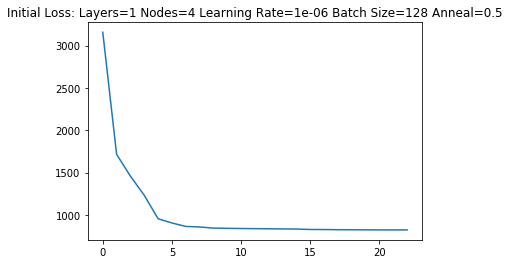

In [104]:
fig = plt.figure()
ax = plt.axes()
x = np.linspace(0, 10, 1000)
ax.set_title(f'Initial Loss: Layers=1 Nodes=4 Learning Rate=1e-06 Batch Size=128 Anneal=0.5' )
ax.plot([i for i in range(0,len(orig_errs))], orig_errs)

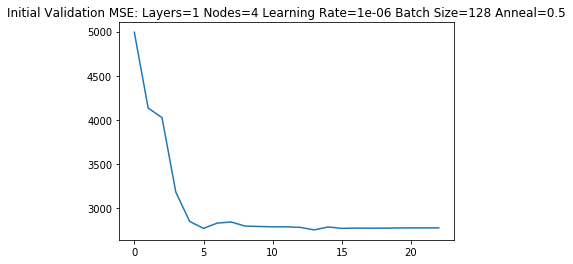

In [105]:
fig = plt.figure()
ax = plt.axes()
x = np.linspace(0, 10, 1000)
ax.set_title(f'Initial Validation MSE: Layers=1 Nodes=4 Learning Rate=1e-06 Batch Size=128 Anneal=0.5' )
ax.plot([i for i in range(0,len(orig_mses))], orig_mses)

In [63]:
orig_errs[len(orig_errs)-1], orig_mses[len(orig_mses)-1]

(824.0616959621502, 2777.127697841128)

In [62]:
preds = test_nn.predict(X_test)
mse = np.mean((preds-y_test)**2)
mse, np.sqrt(mse), y.std()

(1466.3001918420089, 38.29229938044997, 47.821700201078784)

Our base line model had a mean squared error of 1527.34. In order to see what values would work best for the hyperparameters, `layers`,`nodes`, `learning_rate`, `batch_size`, and `anneal`, we created a grid search.

For `layers`, we tested the values 1,2,4,6. For `nodes`, we tested 4,6,8. The values for `learning_rate` were 10E-5, 10E-6, 10E-7. And finally, the values for `batch_size` were 128 and 256 and the values for `anneal` were 0.5 and 0.2.

In [42]:
np.seterr(all='raise')

hyperparameter_dict = {
    "layers": [1,2,4,6],
    "nodes": [4,6,8],
    "learning_rate": [0.00001, 0.000001, 0.0000001],
    "batch_size":[128,256],
    "anneal":[0.5,0.2]
}

iteration = 0
model_dict = {"Initial": [errs,mses,test_nn]}
for a in range(len(hyperparameter_dict["layers"])):
    for b in range(len(hyperparameter_dict["nodes"])):
        for c in range(len(hyperparameter_dict["learning_rate"])):
            for d in range(len(hyperparameter_dict["batch_size"])):
                for e in range(len(hyperparameter_dict["anneal"])):
                    
                    key = str(a)+str(b)+str(c)+str(d)+str(e)
                    try:
                        layers = hyperparameter_dict["layers"][a]
                        nodes = hyperparameter_dict["nodes"][b]
                        learning_rate = hyperparameter_dict["learning_rate"][c]
                        batch_size = hyperparameter_dict["batch_size"][d]
                        anneal = hyperparameter_dict["anneal"][e]
                        key = str(a)+str(b)+str(c)+str(d)+str(e)
                        test_nn = NeuralNetwork(layers, nodes, activation, loss, learning_rate, batch_size, anneal = anneal)
                        model_dict[key] = test_nn.fit(X_train,y_train, X_val, y_val,  mse_diff = mse_diff, max_epochs = max_epochs, print_iter = True)
                        model_dict[key] = list(model_dict[key])
                        model_dict[key].append(test_nn)
                        
                        sys.stdout.write("\r" +"Iteration: "+  str(iteration) +" Complete")
                        iteration+=1
                        sys.stdout.flush() 
                    except:
                        model_dict[key] =(np.nan,np.nan,np.nan)
                    
                    sys.stdout.write("\r" +"Iteration: "+  key +":      "+ str(iteration) +" Complete")
                    iteration+=1
                    sys.stdout.flush() 
                    
                    

Iteration: 32211 Complete

In [43]:
best_acc = []

for key in model_dict:
    test_nn = model_dict[key][2]
    if test_nn:
        try:
            preds = test_nn.predict(X_test)
            mse = np.mean((preds-y_test)**2)
            best_acc.append((key,mse))
    
        except:
            continue
best_acc
best_acc = sorted(best_acc,key=lambda x: x[1])

In [44]:
top_five_models = best_acc[0:5]
top_five_models

#The keys are created with the indices for which parameter in the array for each value in the hyperparameter dict 
# in order of layer, nodes, learning rate, batch_size, and anneal

[('11010', 912.1681970048728),
 ('32100', 920.8304722728134),
 ('22110', 959.9681800522436),
 ('21110', 963.6758333257978),
 ('22100', 1001.5939160687826)]

### Best Model

The best model had the following values for it's hyperparameters.
- Layers:2
- Nodes:6
- Learning Rate:10E-5
- Batch size: 256
- Anneal = 0.5

The mean squared error for this model is 912.17. Looking at the graphs which plot the average loss and validation mean squared errors across epochs, the loss decreased for the most part, fairly steadily, and while the validation dataset's mean squared errors were jumping around in the beginning it eventually began to consistently decrease in a stable manner. The validation accuracy graph was also unstable, but ultimately stabilized. However, it did not stabilize at the lowest mean squared error, implying there were some issues with overfitting in this model.

Looking at the summary statistics of predictions you can see it had difficulty in predicting outliers but did a fairly comparable job in predicting values that were not outliers. 

That being said, the ends of the interquantile range are still off by a nearly half to a million ruble (roughly 6.5k to 13k in USD), so there is definitely room for improvement.

In [65]:
errs = model_dict['11010'][0]
mses = model_dict['11010'][1]
preds = pd.Series(model_dict['11010'][2].predict(X_test))
preds.min(),preds.max(), preds.mean(),preds.median(),preds.quantile(0.25), preds.quantile(0.75)

(26.027827710876903,
 490.59010019792004,
 70.130166470322,
 57.55688345502024,
 53.0432313102064,
 72.34437606183664)

In [205]:
y_test.min(), y_test.max(),y_test.mean(),y_test.median(),y_test.quantile(0.25),y_test.quantile(0.75)

(1.9, 700.0, 70.56163844858895, 62.9824, 47.8556, 81.520875)

In [97]:
def create_title_string(hash_str, typ):
    layer = hyperparameter_dict["layers"][int(hash_str[0])]
    node = hyperparameter_dict["nodes"][int(hash_str[1])]
    lr = hyperparameter_dict["learning_rate"][int(hash_str[2])]
    b_size = hyperparameter_dict["batch_size"][int(hash_str[3])]
    anneal = hyperparameter_dict["anneal"][int(hash_str[4])]
 
    return f'{typ}: Layers={layer} Nodes={node} Learning Rate={lr} Batch Size={b_size} Anneal={anneal}' 

Text(0.5, 1.0, 'Best Loss: Layers=2 Nodes=6 Learning Rate=1e-05 Batch Size=256 Anneal=0.5')

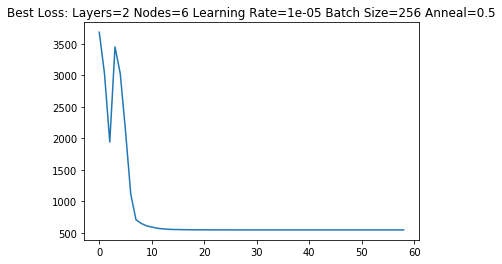

In [106]:
fig = plt.figure()
ax = plt.axes()
x = np.linspace(0, 10, 1000)
ax.plot([i for i in range(0,len(errs))], errs)
ax.set_title("Best " + create_title_string('11010', "Loss"))

Text(0.5, 1.0, 'Best Validation MSE: Layers=2 Nodes=6 Learning Rate=1e-05 Batch Size=256 Anneal=0.5')

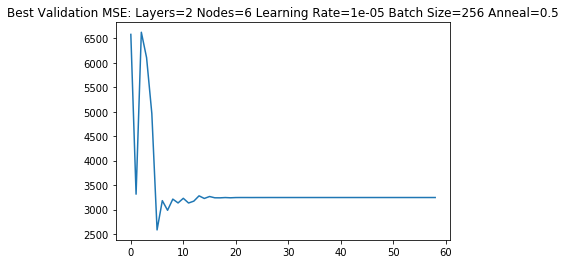

In [107]:
fig = plt.figure()
ax = plt.axes()
x = np.linspace(0, 10, 1000)
ax.plot([i for i in range(0,len(mses))], mses)
ax.set_title("Best " + create_title_string('11010', "Validation MSE"))

In [66]:
errs[len(errs)-1], mses[len(mses)-1]

(519.6525183919234, 3387.0254973887395)

The mean squared errors for the next four best models were 
- 920.83 (layers = 6, nodes = 8, learning_rate = 10E-6, batch_size=128, anneal = 0.5)
- 959.97 (layers = 4, nodes = 8, learning_rate = 10E-6, batch_size=256, anneal = 0.5)
- 963.68 (layers = 4, nodes = 6, learning_rate = 10E-6, batch_size=256, anneal = 0.5)
- 1001.59 (layers = 4, nodes = 8, learning_rate = 10E-6, batch_size=128, anneal = 0.5). 

Looking at the loss graphs of these models, with the exception of the second best model, they all had some difficulty stabilizing in the beginning, but ultimately all converged to a fairly low loss.

However, like our best model, the accuracy graphs for the mean squared error tell a different story. While all the mean squared errors on the validation datasete stabilized, it did not converge around the lowest point either, more signs of overfitting on the training data.

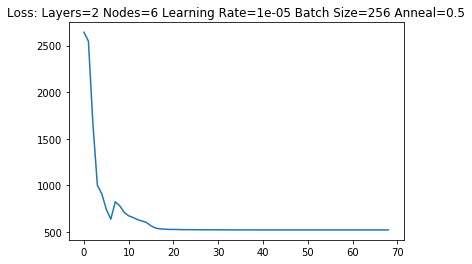

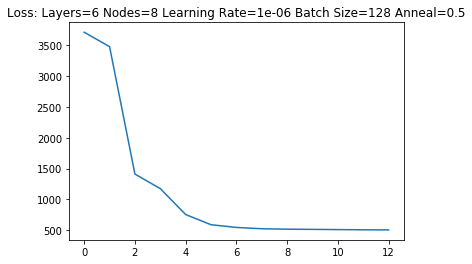

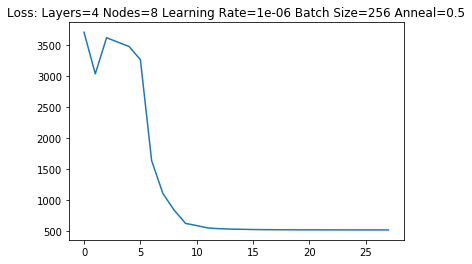

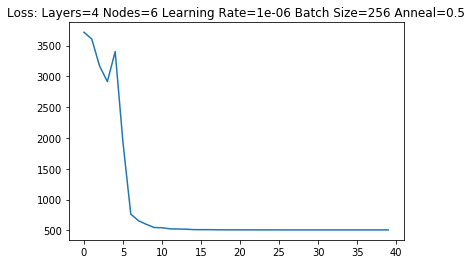

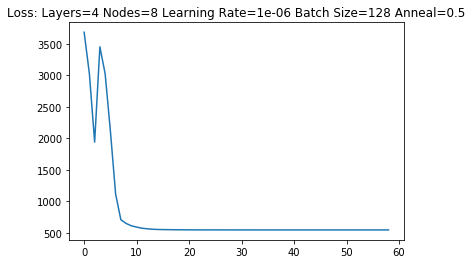

In [109]:
for model in top_five_models:
    errs = model_dict[model[0]][0]
    fig = plt.figure()
    ax = plt.axes()
    x = np.linspace(0, 10, 1000)
    ax.set_title(create_title_string(model[0], "Loss"))
    ax.plot([i for i in range(0,len(errs))], errs)

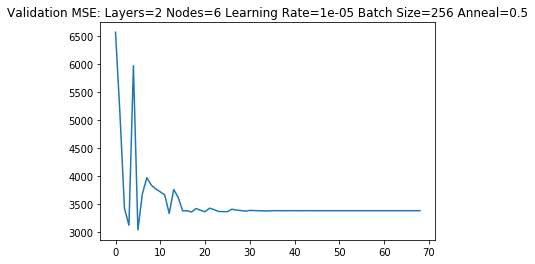

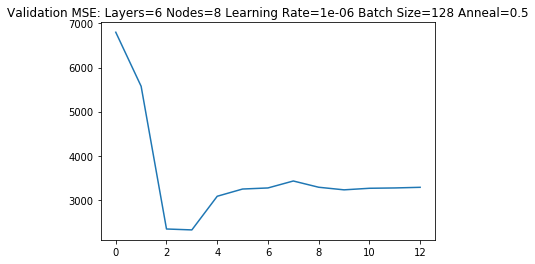

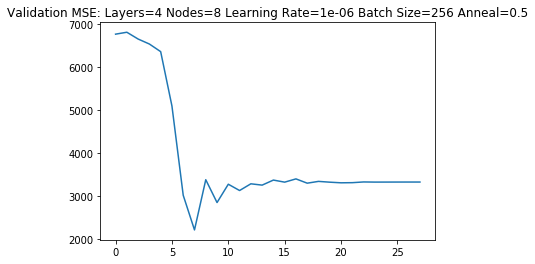

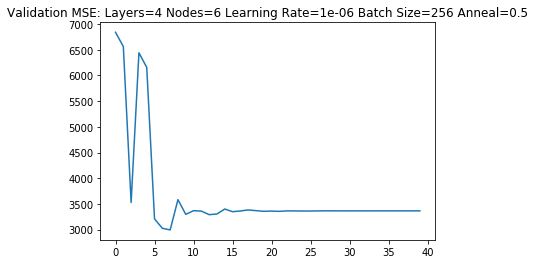

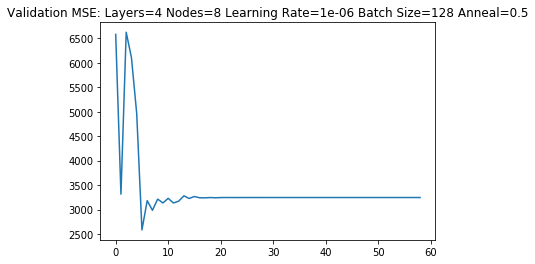

In [110]:
for model in top_five_models:
    mses = model_dict[model[0]][1]
    fig = plt.figure()
    ax = plt.axes()
    x = np.linspace(0, 10, 1000)
    ax.set_title(create_title_string(model[0], "Validation MSE"))
    ax.plot([i for i in range(0,len(mses))], mses)